From https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/

In [1]:
import os
import sys
import json
sys.path.append('../../../../')
sys.path.append('../../../scripts/')

# import log

# LOGGER = log.set_logger('full-tutorial-trainer', logging_level='INFO')
# LOGGER.info('Logger set and running')

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## Prepare Data

In [4]:
folder = '/home/aorus/workspaces/FloodTags/CLEF2019/CLEF-SharedTask3/task3public9may/'

In [5]:
train_conll_file = os.path.join(folder, 'train.txt')
doc_id = 'train'

In [6]:
valid_conll_file = os.path.join(folder, 'dev.txt')
doc_id = 'dev'

In [7]:
test_conll_file = os.path.join(folder, 'task3_test.data')
doc_id = 'test'

In [8]:
china_conll_file = os.path.join(folder, 'china_test.data')
doc_id = 'test'

conll_file = os.path.join(folder, 'china_test.data')
doc_id = 'china'

In [9]:
def parse_conll_sents(file_path, sep='\t'):
    sentences = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        sent = []
        lab = []
        if 'test' not in file_path:
            for line in f.readlines():
                line_ = line.strip().split('\t')
                if line_[0] == '':
                    sentences.append(sent)
                    labels.append(lab)
                    sent = []
                    lab = []
                else:
                    sent.append(line_[0])
                    lab.append(line_[1])
        
        else:
            for line_ in f.readlines():
                line_ = line_.strip()
                if line_ == '':
                    sentences.append(sent)
                    sent = []
                else:
                    sent.append(line_)
    return sentences, labels

In [10]:
tra_sents, y_tra = parse_conll_sents(train_conll_file)

In [11]:
valid_sents, y_val = parse_conll_sents(valid_conll_file)

In [12]:
test_sents, _ = parse_conll_sents(test_conll_file)

In [13]:
china_test_sents, _ = parse_conll_sents(china_conll_file)

In [14]:
words = list({word for sent in (tra_sents + valid_sents) for word in sent})

In [15]:
tags = list({tag for sent in (y_tra + y_val) for tag in sent})

In [16]:
n_words = len(words)
n_tags = len(tags)

## Convert labels to numerical values

In [17]:
word_index = {w: i for i, w in enumerate(words)}
tag_index = {t: i for i, t in enumerate(tags)}

In [18]:
y_tra = [[tag_index[w] for w in s] for s in y_tra]
# y_test = [[tag_index[w] for w in s] for s in y_test]

In [19]:
y_val = [[tag_index[w] for w in s] for s in y_val]

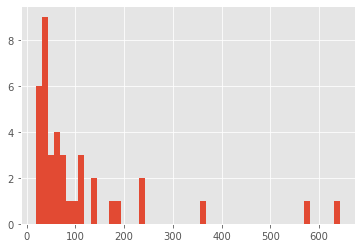

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.hist([len(s) for s in china_test_sents], bins=50)
plt.show()

### Padding

In [21]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [22]:
max_len = 600

In [23]:
X_tra = []
for seq in tra_sents:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    X_tra.append(new_seq)

In [24]:
X_val = []
for seq in valid_sents:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    X_val.append(new_seq)

In [25]:
X_test = []
for seq in test_sents:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    X_test.append(new_seq)

In [26]:
X_china_test = []
for seq in china_test_sents:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("ENDPAD")
    X_china_test.append(new_seq)

In [27]:
y_tra = pad_sequences(maxlen=max_len, sequences=y_tra, padding="post", value=tag_index['O'])
y_val = pad_sequences(maxlen=max_len, sequences=y_val, padding="post", value=tag_index['O'])
# y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag_index['O'])

In [28]:
y_tra.shape, y_val.shape

((250, 600), (36, 600))

## MODEL


In [30]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

In [31]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [32]:
sess = tf.Session()
K.set_session(sess)

In [33]:
batch_size = 2

In [34]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [35]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, 'string')),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [36]:
input_text = Input(shape=(max_len,), dtype='string')

embedding = Lambda(ElmoEmbedding, output_shape=(None, None, max_len, 1024))(input_text)

x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)

x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)

x = add([x, x_rnn])  # residual connection to the first biLSTM

out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

W0809 13:53:49.851917 140490463064192 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 13:53:49.853049 140490463064192 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 13:53:50.105463 140490463064192 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 13:53:50.617024 140490463064192 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_b

In [37]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

W0809 13:53:51.722365 140490463064192 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 13:53:51.733215 140490463064192 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 6 0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 1024)   6295552     lambda_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 1024)   6295552     bidirectional_1[0][0]            
__________________________________________________________________________________________________
add_1 (Add

In [39]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers[1:]]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

# Testing
test = np.array(X_tra[:2])
layer_outs = functor([test, 1.])

In [40]:
type(layer_outs)

list

In [41]:
model.layers[1:]

In [42]:
for l in layer_outs:
    print(l.shape)

(2, 600, 1024)
(2, 600, 1024)
(2, 600, 1024)
(2, 600, 1024)
(2, 600, 17)


### Validation Split

val_split = 0.1

tra_range = int(np.floor((1-val_split)*len(X_tra)/batch_size)*batch_size)
val_range = int(np.floor((val_split)*len(X_tra)/batch_size)*batch_size)
tra_range, val_range

In [29]:
y_tr = y_tra.reshape(y_tra.shape[0], y_tra.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [44]:
history = model.fit(np.array(X_tra), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=30, verbose=1)

Train on 250 samples, validate on 36 samples
Epoch 1/30


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Incompatible shapes: [1200] vs. [2,600]
	 [[{{node metrics/acc/Equal}}]]
	 [[loss/mul/_451]]
  (1) Invalid argument: Incompatible shapes: [1200] vs. [2,600]
	 [[{{node metrics/acc/Equal}}]]
0 successful operations.
0 derived errors ignored.

## Save Model

In [39]:
language = 'en'
topic = 'flood'
classif_name = '{}.{}.clef.elmo.v600.classifier'.format(language, topic)

In [40]:
model_folder = './Model'
model_filepath = os.path.join(model_folder, classif_name + '.h5')
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
model.save(model_filepath)

## Visualise Learning Curves

In [42]:
import pandas as pd

In [43]:
hist = pd.DataFrame(history.history)

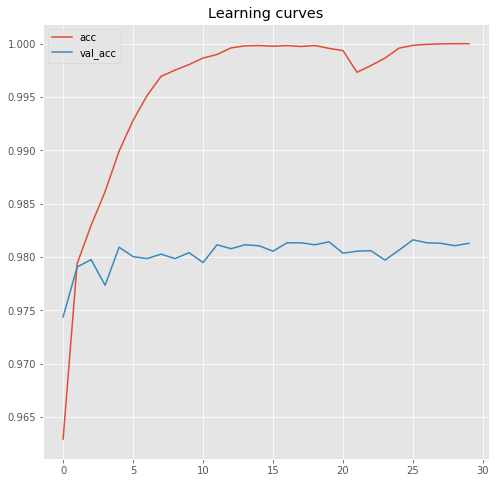

In [44]:
plt.figure(figsize=(8, 8))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.title("Learning curves")
plt.legend()
plt.show()

## Prediction

In [45]:
index_to_word = {i: w for w, i in word_index.items()}
index_to_tag = {i: w for w, i in tag_index.items()}

In [46]:
test_pred = model.predict(np.array(X_test), verbose=1, batch_size=2)

80/80 [==============================] - 52s 646ms/step


In [59]:
X_china_test_first = X_china_test[:38]
X_china_test_last = X_china_test[37:39]

In [60]:
china_test_pred_frst = model.predict(np.array(X_china_test_first), verbose=1, batch_size=2)
china_test_pred_lst = model.predict(np.array(X_china_test_last), verbose=1, batch_size=2)

2/2 [==============================] - 1s 639ms/step


In [61]:
china_test_pred = np.concatenate((china_test_pred_frst, 
                                  china_test_pred_lst[1:2]))

In [62]:
len(china_test_pred)

39

In [63]:
def pred2label(labels, X_test, word_index, index_to_tag, y_true=False):
    out = []
    for sent, sent_labels in zip(X_test, labels):
        out_sent = []
        for token, token_label in zip(sent, sent_labels):
            if token != 'ENDPAD':
                if not y_true:
                    token_label = np.argmax(token_label)
                out_sent.append(index_to_tag[token_label])
        out.append(out_sent)
    return out

In [64]:
pred_labels = pred2label(test_pred, X_test, word_index, index_to_tag, y_true=False)
china_pred_labels = pred2label(china_test_pred, X_china_test, word_index, index_to_tag, y_true=False)

In [65]:
len([w for s in pred_labels for w in s])#, len([w for s in test_labels for w in s])

6506

# Write to CONLL

In [55]:
out_fol = '/home/aorus/workspaces/FloodTags/CLEF2019/CLEF-SharedTask3/task3public9may/predictions/'

In [56]:
result_file = open(out_fol + 'clef.test.results.conll.out', 'w')

for si, sent in enumerate(X_test): 
    
    for ti, token in enumerate(sent):
        
        if token != 'ENDPAD':
    
            result_file.write(token
                              + '\t' + pred_labels[si][ti] + '\n')
        
    result_file.write('\n')
    
result_file.close()

# os.system('perl ' + NEAT_DATA + '/conlleval.pl <  ' + 
#           classif_spesific_path + '.results.conll.out > ' + classif_spesific_path + '.test.scores.out')

In [66]:
for si, sent in enumerate(china_pred_labels):
    
    if len(sent) < len(china_test_sents[si]):
        
        print(len(sent), len(china_test_sents[si]))
        
        diff = len(china_test_sents[si]) - len(sent)
        sent += ['O']*diff
        print(len(sent))

600 643
643


In [67]:
result_file = open(out_fol + 'clef.china.results.conll.out', 'w')

for si, sent in enumerate(china_test_sents): 
    
    for ti, token in enumerate(sent):
        
        if token != 'ENDPAD':
    
            result_file.write(token
                              + '\t' + china_pred_labels[si][ti] + '\n')
        
    result_file.write('\n')
    
result_file.close()

# os.system('perl ' + NEAT_DATA + '/conlleval.pl <  ' + 
#           classif_spesific_path + '.results.conll.out > ' + classif_spesific_path + '.test.scores.out')